# Auto-ARIMA and Prophet Experiments

This notebook explores automated ARIMA (pmdarima auto_arima) workflows and Facebook Prophet for handling changepoints, holidays and events. It builds on the cleaned merged dataset produced in `0_Data_preprocess_eda.ipynb`.

What this notebook covers:
- Automated model selection with `pmdarima.auto_arima` and guidance on ndiffs/nsdiffs.
- Prophet examples with custom holidays and manual changepoints for energy-market events.
- Iterative day-by-day Prophet forecasting (useful to simulate a production-like rolling update).

Quick run tips:
- Prophet and auto_arima can take significant time on long series; use the `start_date`/`end_date` variables to limit scope for quick previews.
- Keep the `holidays` DataFrame and changepoints handy — they are helpful when forecasting around structural events.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the style of seaborn
sns.set(style="whitegrid")

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from pmdarima.utils import tsdisplay
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pmdarima as pm

%matplotlib widget

# Data and plot

In [3]:
file_path = 'price_vol_temp_inven_mc_merged_cleaned_data.csv'
# Load the data
df = pd.read_csv(file_path, parse_dates=['date'])

# Set the date as index
df['date'] = df['date'].dt.date

# Set the date as index
#df.set_index('date', inplace=True)
#df.reset_index(inplace=True)

# Preview the data
df

,date,psv_price,brent_price,ttf_futures_price,pvb_price,jkm_price,nbp_price,cboe_price,coal_price,hh_price,...,ttfmc9_close,jkm_volume,jkm_temperature,hh_temperature,ttf_temperature,psv_temperature,pvb_temperature,peg_temperature,nwe_storage,us_storage
0,2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,6.193716,6.266269,0.094442,7.786285,10.795788,6.314228,NaN,NaN
1,2009-01-02,NaN,46.91,NaN,NaN,NaN,NaN,39.19,74.35,5.41,...,NaN,NaN,7.335959,17.224785,1.579225,5.998459,10.847691,4.856506,NaN,NaN
2,2009-01-05,NaN,49.62,NaN,NaN,NaN,NaN,39.08,77.65,5.83,...,NaN,NaN,7.944893,10.890604,-1.820566,4.762669,5.153366,3.026861,NaN,NaN
3,2009-01-06,NaN,50.53,NaN,NaN,NaN,NaN,38.56,81.25,6.10,...,NaN,NaN,8.328867,9.658951,-5.407801,5.306755,6.051567,-0.464495,NaN,NaN
4,2009-01-07,NaN,45.86,NaN,NaN,NaN,NaN,43.39,78.65,5.89,...,NaN,NaN,8.126515,5.560003,-0.357938,5.814152,4.029930,-1.189952,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,2025-07-07,NaN,69.31,33.621,NaN,NaN,NaN,18.05,NaN,NaN,...,33.6730,NaN,29.114191,25.342670,19.326149,28.335629,29.425678,21.005398,NaN,3025.714286
4308,2025-07-08,NaN,NaN,34.210,NaN,NaN,NaN,NaN,NaN,NaN,...,33.9530,NaN,29.781725,26.281120,19.311378,27.080639,27.589233,22.544525,NaN,3032.285714
4309,2025-07-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.7045,NaN,29.436270,24.749405,21.166391,26.408058,28.702595,24.432117,NaN,3038.857143
4310,2025-07-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,34.5830,NaN,28.142267,24.877296,23.507310,26.605621,29.390648,25.492271,NaN,3045.428571


# Load the city temperature data

In [4]:
# Load the CSV file
t_file = 'temperature_data_6_regions.csv'
df_t = pd.read_csv(t_file, parse_dates=['date'])

# Keep only the date part (remove time)
df_t['date'] = df_t['date'].dt.date

# Set the date as index
#df_t.set_index('date', inplace=True)

# Preview data
df_t

,date,jkm,hh,ttf,psv,pvb,peg
0,2009-01-01,6.193716,6.266269,0.094442,7.786285,10.795788,6.314228
1,2009-01-02,7.335959,17.224785,1.579225,5.998459,10.847691,4.856506
2,2009-01-03,8.181699,19.955269,-0.503795,6.077274,9.228043,5.211918
3,2009-01-04,8.029143,20.170723,1.274718,5.009335,8.835560,2.518314
4,2009-01-05,7.944893,10.890604,-1.820566,4.762669,5.153366,3.026861
...,...,...,...,...,...,...,...
6030,2025-07-06,29.699951,25.465096,22.737580,29.723503,30.455544,22.723580
6031,2025-07-07,29.114191,25.342670,19.326149,28.335629,29.425678,21.005398
6032,2025-07-08,29.781725,26.281120,19.311378,27.080639,27.589233,22.544525
6033,2025-07-09,29.436270,24.749405,21.166391,26.408058,28.702595,24.432117


# Auto-arima

## Functions

In [5]:
# Define function to fit ARIMA/SARIMAX model and forecast the next 100 periods
def data_prep(df, column, date_range=None):
    """
    Prepare the time series data for the specified column.
    
    Parameters:
    - df: DataFrame containing the time series data
    - column: Column name to prepare the data for
    - date_range: Optional tuple (start_date, end_date) to filter the series

    Returns:
    - series: The prepared time series DataFrame with date as index
    """
    # Prepare the series with date as index
    series = df[['date', column]].dropna(subset=[column])
    series = series.set_index('date')
    series = series.asfreq('B').interpolate()  # Business frequency daily

    if date_range is not None:
        if isinstance(date_range, tuple) and len(date_range) == 2:
            # Ensure date_range is a tuple of two dates
            date_range = pd.to_datetime(date_range)
        elif isinstance(date_range, pd.DatetimeIndex):
            # If date_range is a DatetimeIndex, convert to tuple
            date_range = (date_range[0], date_range[-1])
        else:
            raise ValueError("date_range must be a tuple of two dates or a DatetimeIndex.")
        # Filter the series based on the date range
        series = series[date_range[0]:date_range[1]]

    return series

def exog_prep_train_test(df, exog_column, data_train, steps=100):
    """
    Prepare exogenous variables for the model.
    
    Parameters:
    - df: DataFrame containing the time series data
    - exog_column: Column name to prepare the exogenous variable for
    - data_train: Training data series to align with
    - steps: Number of periods to forecast

    Returns:
    - exog: Prepared exogenous variable DataFrame with date as index
    """
    # Prepare the exogenous variable series
    exog_train = data_prep(df, exog_column, date_range=data_train.index)

    # Align with training data index
    exog_train = exog_train.reindex(data_train.index).fillna(0)

    # Extend for forecast period
    forecast_index = pd.date_range(start=data_train.index[-1] + pd.Timedelta(days=1), periods=steps, freq='B')
    exog_test = data_prep(df, exog_column, date_range=(forecast_index[0], forecast_index[-1]))

    # Check if exogenous variables contains any NaN values
    if exog_train.isnull().values.any():
        print("Warning: Exogenous variables contain NaN values. Filling with 0.")
        exog_train = exog_train.fillna(0)

    if exog_test.isnull().values.any():
        print("Warning: Exogenous variables for forecast contain NaN values. Filling with 0.")
        exog_test = exog_test.fillna(0)

    return exog_train, exog_test

def fit_arima_sarimax_and_forecast(series, order=(1, 1, 1), 
                                   seasonal_order=None, steps=100, print_summary=False, exog_train=None, exog_test=None):
    
    """
    Fit an ARIMA or SARIMAX model to the specified column and forecast the next `steps` periods.
    If `seasonal_order` is provided, SARIMAX is used; otherwise, ARIMA is used.
    
    Parameters:
    - df: DataFrame containing the time series data
    - column: Column name to fit the model on
    - date_range: Optional tuple (start_date, end_date) to filter the series
    - order: Tuple specifying the (p, d, q) order of the ARIMA/SARIMAX model
    - seasonal_order: Tuple (P, D, Q, s) for SARIMAX seasonality, or None for ARIMA
    - steps: Number of periods to forecast
    - print_summary: Whether to print the model summary
    - exog: Optional exogenous variables for SARIMAX

    Returns:
    - series: The time series used for fitting (DataFrame)
    - results: Fitted model results
    - forecast_index: Index for the forecasted values
    - forecast: Forecasted values object
    """
    # Prepare exogenous variables if provided
    exog_fit = None
    if exog_train is not None:
        exog_fit = exog_train.loc[series.index] if isinstance(exog_train, pd.DataFrame) else exog_train

    # Select model
    if seasonal_order is not None:
        model = SARIMAX(series, order=order, seasonal_order=seasonal_order, exog=exog_fit)
    else:
        model = ARIMA(series, order=order, exog=exog_fit)

    results = model.fit()

    if print_summary:
        print(results.summary())

    # Forecast
    forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=steps, freq='B')
    exog_forecast = None
    if exog_test is not None:
        # For forecasting, exog must have the same number of rows as steps
        if isinstance(exog_test, pd.DataFrame):
            exog_forecast = exog_test.reindex(forecast_index)
        else:
            exog_forecast = exog_test

    forecast = results.get_forecast(steps=steps, exog=exog_forecast)

    return results, forecast_index, forecast

# Plot the model fit and forecast, confidence intervals
def plot_forecast(series_train, fitted_values, forecast_values, conf_int, forecast_index, ylabel='Price', series_other=None, title=None):
    """
    Plot the model fit and forecast with confidence intervals.
    
    Parameters:
    - series: Original time series data (DataFrame)
    - fitted_values: Fitted values from the model (Series)
    - forecast_values: Forecasted values (Series)
    - conf_int: Confidence intervals for the forecast (Numpy array)
    - forecast_index: Index for the forecasted values (DatetimeIndex)
    """

    plt.figure(figsize=(10, 6))

    # Plot observed data
    plt.plot(series_train.index, series_train, label='Train', color='blue')

    # Plot fitted values
    plt.plot(series_train.index, fitted_values, label='Fitted', color='green', alpha=0.5)

    if series_other is not None:
        # Plot other series if provided
        plt.plot(series_other.index, series_other, label='Test', color='orange', linestyle='-')

    # Plot forecasted values
    plt.plot(forecast_index, forecast_values, label='Forecast', color='red')

    # Plot confidence intervals
    plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

    plt.xlabel('Date')
    plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    else:
        plt.title('Model Fit and Forecast')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# --- Event impact windows and step changes for exogenous features ---
def add_event_features_hh(df, idx_col='date'):
    """
    Add binary indicator columns for major LNG/gas market events.
    Assumes df[idx_col] is datetime and set as index or column.
    """
    # Ensure datetime index
    if idx_col in df.columns:
        df = df.copy()
        df[idx_col] = pd.to_datetime(df[idx_col])
        df = df.set_index(idx_col)
    else:
        df = df.copy()
        df.index = pd.to_datetime(df.index)

    # Define event features as a dictionary: {column_name: (start_date, end_date, type)}
    # type: 'step' for step change, 'window' for event window
    event_features = {
        'event_shale_gas_2012':         ('2012-04-01', None, 'step'),
        'event_polar_vortex_2014':      ('2014-01-15', '2014-03-15', 'window'),
        'event_mild_winter_2016':       ('2015-12-01', '2016-03-31', 'window'),
        'event_cold_snap_2018':         ('2018-11-01', '2019-02-28', 'window'),
        'event_covid_shock_2020':       ('2020-03-01', '2020-09-30', 'window'),
        'event_post_covid_2021':        ('2021-10-01', None, 'step'),
        'event_ukraine_war_acute_2022': ('2022-02-24', '2022-12-31', 'window'),
        'event_ukraine_war_step_2022':  ('2022-02-24', None, 'step'),
        'event_freeport_outage_2022':   ('2022-06-08', '2022-11-15', 'window'),
        'event_nordstream_halt_2022':   ('2022-08-31', None, 'step'),
        'event_eu_price_cap_2022':      ('2022-12-19', '2023-03-31', 'window'),
        'event_warm_winter_2023':       ('2023-03-01', '2023-06-30', 'window'),
        'event_lng_capacity_2024':      ('2024-01-01', None, 'step'),
    }

    for col, (start, end, typ) in event_features.items():
        if typ == 'step':
            df[col] = (df.index >= pd.to_datetime(start)).astype(int)
        elif typ == 'window':
            df[col] = ((df.index >= pd.to_datetime(start)) & (df.index <= pd.to_datetime(end))).astype(int)

    return df

## Check n-diff

In [6]:
# Test number of differences needed to make the series stationary
from pmdarima.arima import ndiffs, nsdiffs

series = data_prep(df, 'ttf_price', date_range=('2000-01-01', '2021-12-31'))

# Calculate the number of differences needed to make the series stationary
n_diffs = ndiffs(series['ttf_price'], test='adf')  # m=365 for weekly seasonality
print(f"Number of differences needed: {n_diffs}")

# Calculate the number of seasonal differences needed
seasonal_diffs = nsdiffs(series['ttf_price'], m=5)  # m=5 for weekly seasonality
print(f"Number of seasonal differences needed: {seasonal_diffs}")

Number of differences needed: 1
Number of seasonal differences needed: 0


In [8]:
# Auto ARIMA/SARIMAX model fitting and forecasting with exogenous variables

whc = 'hh_price'  # Change to the column you want to analyze
whct = whc.split('_')[0]  # Extract the prefix for temperature column
start_date = '2010-01-01'
end_date = '2020-06-30'
end_date = '2020-12-21'

# Prepare data series (must be 1D, no missing values)
series = data_prep(df, whc, date_range=(start_date, end_date))

forecast_steps = 250
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

#############################
# Prepare exogenous variables
#############################
# Lag temperature features from df_t
exog_train_list = []
exog_test_list = []
for lag in [0, 1, 2, 6, 12, 24, 36, 48, 96]:
    df_t[whct + f'_t_lag{lag}'] = df_t[whct].shift(lag)
    s_train, s_test = exog_prep_train_test(df_t, whct + f'_t_lag{lag}', series, steps=forecast_steps)
    exog_train_list.append(s_train)
    exog_test_list.append(s_test)
# Concatenate the lagged temperature features
exog_train = pd.concat(exog_train_list, axis=1)
exog_test = pd.concat(exog_test_list, axis=1)

# Temperature^2
df_t[whct + '_t_squared'] = df_t[whct] ** 2
s_train, s_test = exog_prep_train_test(df_t, whct + '_t_squared', series, steps=forecast_steps)
exog_train = pd.concat([exog_train, s_train], axis=1)
exog_test = pd.concat([exog_test, s_test], axis=1)

# Extreme temperature features
# df_t[whct + '_t_extreme_hot'] = df_t[whct].apply(lambda x: 1 if (x > 25) else 0)  # Example threshold for extreme temperature
# s_train, s_test = exog_prep_train_test(df_t, whct + '_t_extreme_hot', series, steps=forecast_steps)
# exog_train = pd.concat([exog_train, s_train], axis=1)
# exog_test = pd.concat([exog_test, s_test], axis=1)

df_t[whct + '_t_extreme_cold'] = df_t[whct].apply(lambda x: 1 if (x < 3) else 0)  # Example threshold for extreme temperature
s_train, s_test = exog_prep_train_test(df_t, whct + '_t_extreme_cold', series, steps=forecast_steps)
exog_train = pd.concat([exog_train, s_train], axis=1)
exog_test = pd.concat([exog_test, s_test], axis=1)

# Categorical variables for Covid-19 and war in Ukraine and other significant events
# Create binary variables for significant events
exog_train = add_event_features_hh(exog_train, idx_col=exog_train.index.name)
exog_test = add_event_features_hh(exog_test, idx_col=exog_test.index.name)

# Remove any constant columns, depending on the fit range for the window/step indicators
mask = (exog_train != exog_train.iloc[0]).any()
exog_train = exog_train.loc[:, mask]
exog_test = exog_test.loc[:, mask]

# Standardize the data, exogenous variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
series_scaled = pd.DataFrame(scaler.fit_transform(series), index=series.index, columns=series.columns)
scaler_exog = StandardScaler()
exog_train_scaled = pd.DataFrame(scaler_exog.fit_transform(exog_train), index=exog_train.index, columns=exog_train.columns)
exog_test_scaled = pd.DataFrame(scaler_exog.transform(exog_test), index=exog_test.index, columns=exog_test.columns)

# Fit the ARIMA model using auto_arima
# Note: auto_arima will automatically determine the best order for ARIMA/SARIMAX
model = pm.auto_arima(series_scaled, exog_train_scaled,
    seasonal=False,
    m=1,  # set to your seasonal period (e.g., 5 for weekly, 12 for monthly)
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(model.summary())

forecast, conf_int = model.predict(n_periods=forecast_steps, X=exog_test_scaled, return_conf_int=True)
forecast_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='B')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1815.123, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1815.123, Time=0.67 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1841.433, Time=1.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1841.433, Time=1.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1860.731, Time=1.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1860.731, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1816.990, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1816.990, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1898.860, Time=2.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1898.860, Time=2.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2046.795, Time=2.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2046.795, Time=2.14 sec
 ARIMA(2,1,0)(0,0,0)[0] interce

In [9]:
# drop the exogenous variables in the df_t DataFrame
for col in exog_train.columns:
    if col in df_t.columns:
        df_t.drop(columns=col, inplace=True)
    if col in df.columns:
        df.drop(columns=col, inplace=True)

Mean Absolute Error (MAE): 4.46413
R^2 Score: -6.26050


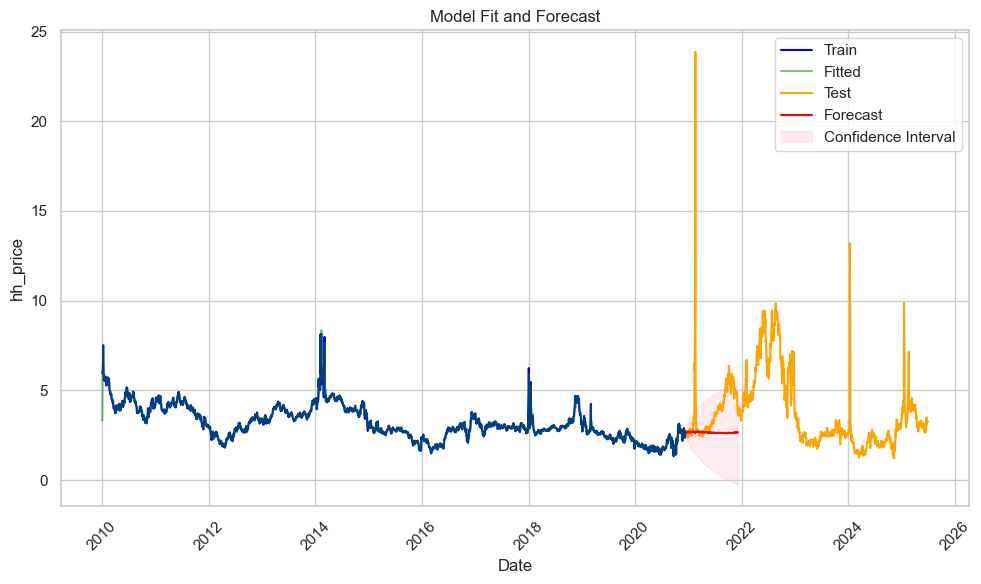

In [13]:
# Calculate MAE and R^2 for the forecast
from sklearn.metrics import mean_absolute_error, r2_score
actual = data_prep(df, whc, forecast_index)
forecast = pd.Series(forecast, index=forecast_index, name='predicted_mean')
mae = mean_absolute_error(actual, forecast)
r2 = r2_score(actual, forecast)
print(f"Mean Absolute Error (MAE): {mae:.5f}")
print(f"R^2 Score: {r2:.5f}")

plot_forecast(
    series, 
    scaler.inverse_transform(model.predict_in_sample(X=exog_train_scaled).values.reshape(-1, 1)),
    scaler.inverse_transform(forecast.values.reshape(-1, 1)),
    scaler.inverse_transform(conf_int),
    forecast_index,
    series_other=data_prep(df, whc, date_range=(end_date, '2025-12-31')),
    ylabel=whc
)

In [14]:
# Plotly plot for the global inventory in the df DataFrame
import plotly.express as px

fig = px.line(df, x='date', y=['hh_price', 'inventories_global'], title='Global Inventory Over Time')
fig.show()

In [15]:
# Plotly plot check the new lag, squared, and extreme temperature features
import plotly.express as px

# Prepare the data for Plotly
exog_train_melted = exog_train.reset_index().melt(id_vars='date', var_name='feature', value_name='value')
exog_test_melted = exog_test.reset_index().melt(id_vars='date', var_name='feature', value_name='value')

# Plot the training data
fig = px.line(exog_train_melted, x='date', y='value', color='feature', title='Exogenous Variables (Training)')
fig.show()

# Plot the test data
fig = px.line(exog_test_melted, x='date', y='value', color='feature', title='Exogenous Variables (Test)')
fig.show()

# Prophet

Comparison between Prophet and ES

| Aspect                | Prophet                                              | Exponential Smoothing (Holt-Winters)         |
|-----------------------|-----------------------------------------------------|----------------------------------------------|
| **Trend**             | Flexible, can model piecewise linear or logistic    | Linear or exponential (additive/multiplicative) |
| **Seasonality**       | Multiple, automatically detected, can be non-integer| Single, fixed period, must be specified      |
| **Holidays/Events**   | Can include custom holidays/regressors              | Not natively supported                       |
| **Missing Data**      | Handles missing data well                           | Requires regular time steps, less robust     |
| **Modeling Approach** | Additive regression with components                 | Smoothing past values with weighted averages |
| **Interpretability**  | Decomposable, interpretable components              | Decomposable, but less flexible              |
| **Automation**        | More automated, less parameter tuning needed        | Requires manual selection of trend/seasonal  |

**Summary:**  
- **Prophet** is more flexible, robust to missing data, and easier for complex seasonality and holidays.
- **Exponential Smoothing** is classical, fast, and works well for regular, simple seasonal/trend data.

Here are some useful parameters for the `Prophet` model:

| Parameter                | Description                                                                                  |
|--------------------------|---------------------------------------------------------------------------------------------|
| `growth`                 | Trend type: `'linear'` (default) or `'logistic'`                                            |
| `changepoints`           | List of dates where trend changes, or let Prophet automatically select                      |
| `n_changepoints`         | Number of potential changepoints (default: 25)                                              |
| `changepoint_range`      | Proportion of history in which trend changepoints will be estimated (default: 0.8)          |
| `yearly_seasonality`     | Fit yearly seasonality: `True`, `False`, or integer (number of Fourier terms)               |
| `weekly_seasonality`     | Fit weekly seasonality: `True`, `False`, or integer                                         |
| `daily_seasonality`      | Fit daily seasonality: `True`, `False`, or integer                                          |
| `seasonality_mode`       | `'additive'` (default) or `'multiplicative'`                                                |
| `seasonality_prior_scale`| Strength of seasonality regularization (default: 10.0)                                      |
| `holidays`               | DataFrame with custom holidays/events                                                       |
| `holidays_prior_scale`   | Strength of holiday effect regularization (default: 10.0)                                   |
| `interval_width`         | Width of uncertainty intervals (default: 0.80 for 80%)                                      |
| `uncertainty_samples`    | Number of simulated draws for uncertainty intervals (default: 1000)                         |

**Example usage:**




You can also add custom seasonality and holidays for more control.

In [16]:
# Mapping from price column to hosting country
price_column_country = {
    'brent_price': 'UK',
    'cboe_price': 'US',
    'coal_price': 'Australia',
    'hh_price': 'US',
    'jkm_price': 'Japan/Korea',
    'nbp_price': 'UK',
    'psv_price': 'Italy',
    'ttf_price': 'Netherlands'
}

In [17]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13


In [18]:
wartime = pd.DataFrame([
    {'holiday': 'wartime', 'ds': '2022-02-24', 'lower_window': 0, 'ds_upper': '2023-01-31'},
])
for t_col in ['ds', 'ds_upper']:
    wartime[t_col] = pd.to_datetime(wartime[t_col])
wartime['upper_window'] = (wartime['ds_upper'] - wartime['ds']).dt.days

wartime

,holiday,ds,lower_window,ds_upper,upper_window
0,wartime,2022-02-24,0,2023-01-31,341


In [19]:
other_holidays = pd.DataFrame([
    {'holiday': 'european_gas_storage_record', 'ds': '2023-06-01', 'lower_window': 0, 'ds_upper': '2023-06-01'},
    {'holiday': 'european_gas_storage_record', 'ds': '2023-06-01', 'lower_window': 0, 'ds_upper': '2023-06-01'},
])

In [21]:
holidays = pd.concat((lockdowns, wartime), ignore_index=True)
holidays

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-21,0,2020-06-06,77
1,lockdown_2,2020-07-09,0,2020-10-27,110
2,lockdown_3,2021-02-13,0,2021-02-17,4
3,lockdown_4,2021-05-28,0,2021-06-10,13
4,wartime,2022-02-24,0,2023-01-31,341


In [ ]:
# Fit raw Prophet model
from prophet import Prophet

whc = 'hh_price' # 'ttf_price'
#whc = 'ttf_price' # 'hh_price'

# Prepare the data for Prophet
start_date = '2000-01-01'
#start_date = '2023-01-01'
end_date = '2024-06-30'
series = data_prep(df, whc, date_range=(start_date, end_date))
series_other = data_prep(df, whc, date_range=(end_date, '2025-12-31'))
df_prophet = series.reset_index().rename(columns={'date': 'ds', whc: 'y'})

# Fit the Prophet model
model = Prophet(n_changepoints=50, changepoint_prior_scale=0.1, holidays=holidays, changepoint_range=0.95, weekly_seasonality=False)
model.add_country_holidays(country_name=price_column_country[whc])

model.fit(df_prophet)

future = model.make_future_dataframe(periods=365, freq='B')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

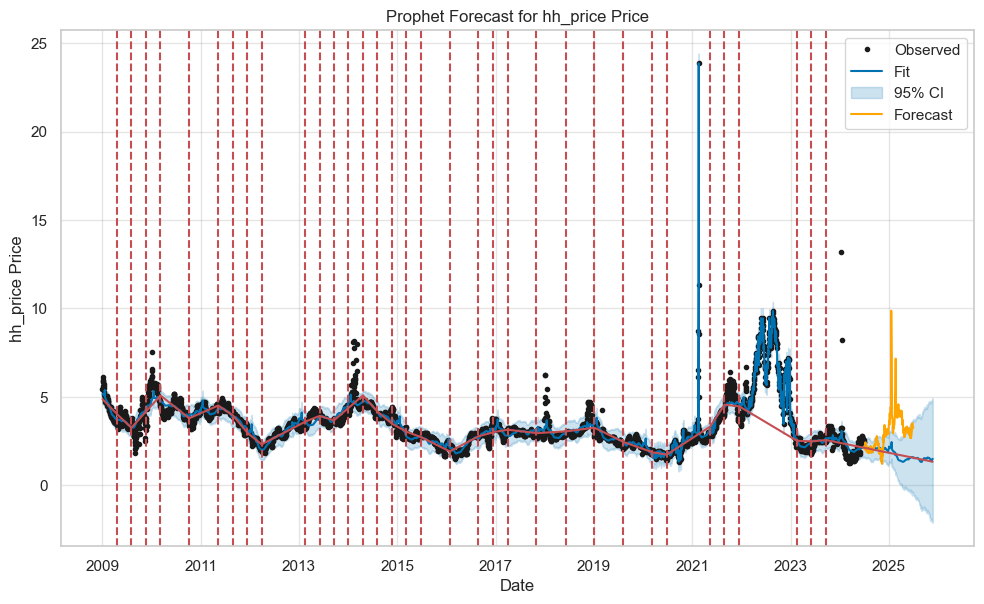

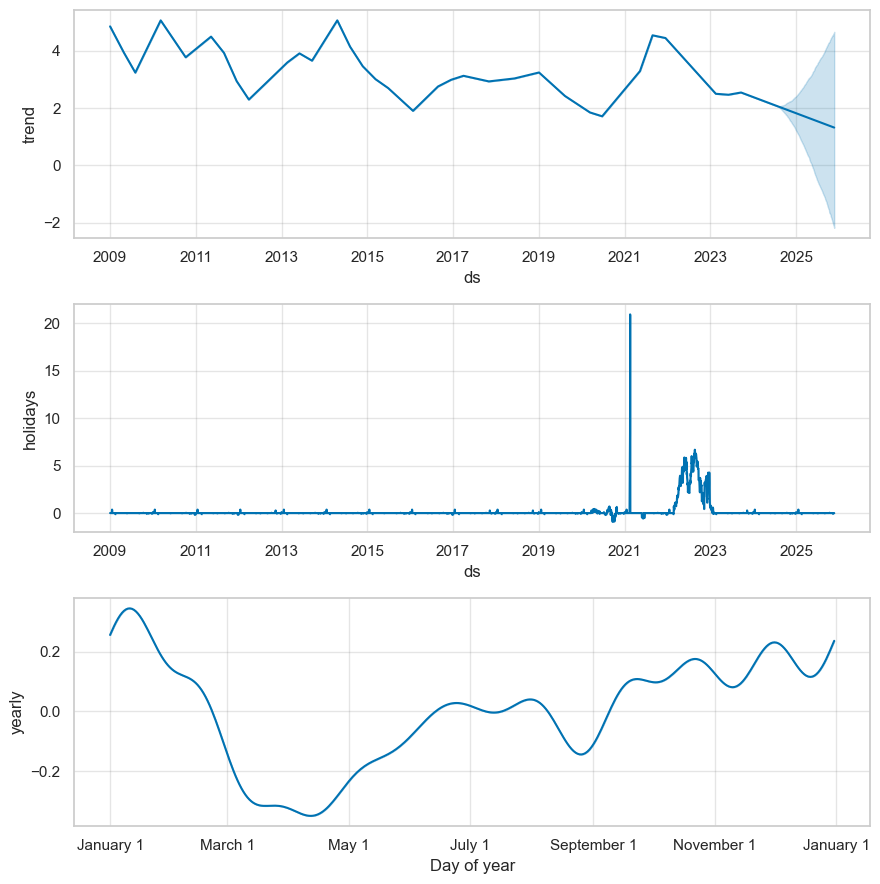

In [23]:
# plot the Prophet forecast
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
plt.plot(series_other.index, series_other, label='Test', color='orange', linestyle='-')
fig.set_size_inches(10, 6)
plt.title(f'Prophet Forecast for {whc} Price')
plt.xlabel('Date')
plt.ylabel(f'{whc} Price')
plt.legend(['Observed', 'Fit', '95% CI', 'Forecast'])

a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

model.plot_components(forecast)

plt.show()

22:30:44 - cmdstanpy - INFO - Chain [1] start processing
22:30:44 - cmdstanpy - INFO - Chain [1] done processing


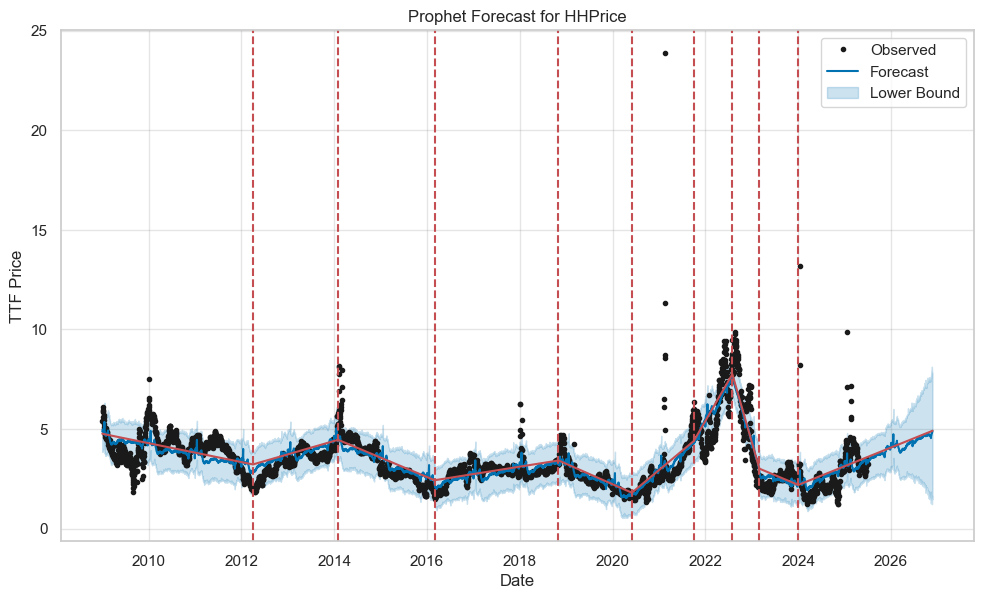

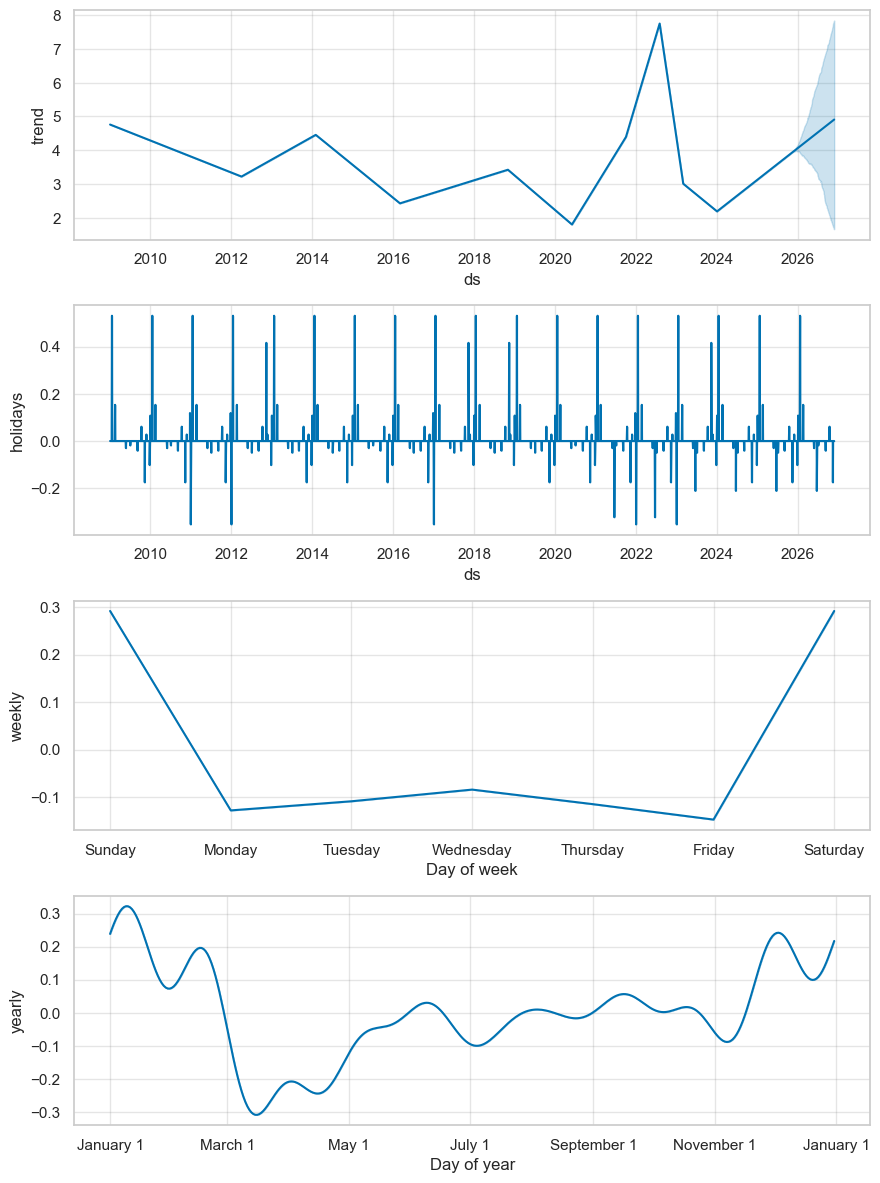

In [24]:
# Fit Prophet model with changepoints for Covid-19 and Russia-Ukraine war

changepoints = [
    '2011-03-11',  # Fukushima disaster
    '2014-06-01',  # Oil price crash begins
    '2015-07-01',  # Australian LNG supply surge
    '2017-01-01',  # China coal-to-gas switch
    '2018-07-01',  # US-China trade war/tariffs
    '2020-03-11',  # WHO declares Covid-19 pandemic
    #'2021-10-01',  # European energy crisis begins
    #'2022-02-24',  # Russia invades Ukraine
    '2022-06-08',  # Freeport LNG fire (US export outage)
    #'2022-12-19',  # EU gas price cap agreement
    '2023-01-01',  # Mild winter, high EU storage
    '2024-01-01',  # New Qatar/US/Africa LNG supply expected
    # Covid-19 and Russia-Ukraine war dates
    '2020-01-01', '2020-03-11', '2020-04-01', '2020-06-01', '2020-09-01', '2021-01-01',
    '2021-10-01', '2022-02-24', '2022-03-07', '2022-06-14', '2022-07-11', '2022-07-21',
    '2022-08-31', '2022-09-26', '2022-12-19', '2023-01-01', '2023-06-01'
]

hh_changepoints = [
    '2012-04-01',  # Historic low: shale gas boom, oversupply
    '2014-02-01',  # Peak: Polar vortex, extreme cold
    '2016-03-01',  # Valley: mild winter, high production
    '2018-11-01',  # Peak: early cold snap, low storage
    '2020-06-01',  # Valley: Covid-19 demand collapse
    '2021-10-01',  # Peak: post-pandemic demand, LNG exports surge
    '2022-08-01',  # Peak: Russia-Ukraine war, global gas crisis
    '2023-03-01',  # Valley: warm winter, high storage, Freeport outage
    '2024-01-01',  # Volatility: new LNG export capacity, global events
]

whc = 'hh_price' # 'hh_price'

# Prepare the data for Prophet
start_date = '2000-01-01'
end_date = '2025-06-30'
series = data_prep(df, whc, date_range=(start_date, end_date))
df_prophet = series.reset_index().rename(columns={'date': 'ds', whc: 'y'})

# Fit the Prophet model
model = Prophet(changepoints=hh_changepoints, n_changepoints=50)
model.add_country_holidays(country_name=price_column_country[whc])
model.fit(df_prophet)

future = model.make_future_dataframe(periods=365, freq='B')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# plot the Prophet forecast
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
fig.set_size_inches(10, 6)
plt.title('Prophet Forecast for HHPrice')
plt.xlabel('Date')
plt.ylabel('TTF Price')
plt.legend(['Observed', 'Forecast', 'Lower Bound', 'Upper Bound'])

a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

model.plot_components(forecast)
plt.show()

22:33:37 - cmdstanpy - INFO - Chain [1] start processing
22:33:38 - cmdstanpy - INFO - Chain [1] done processing


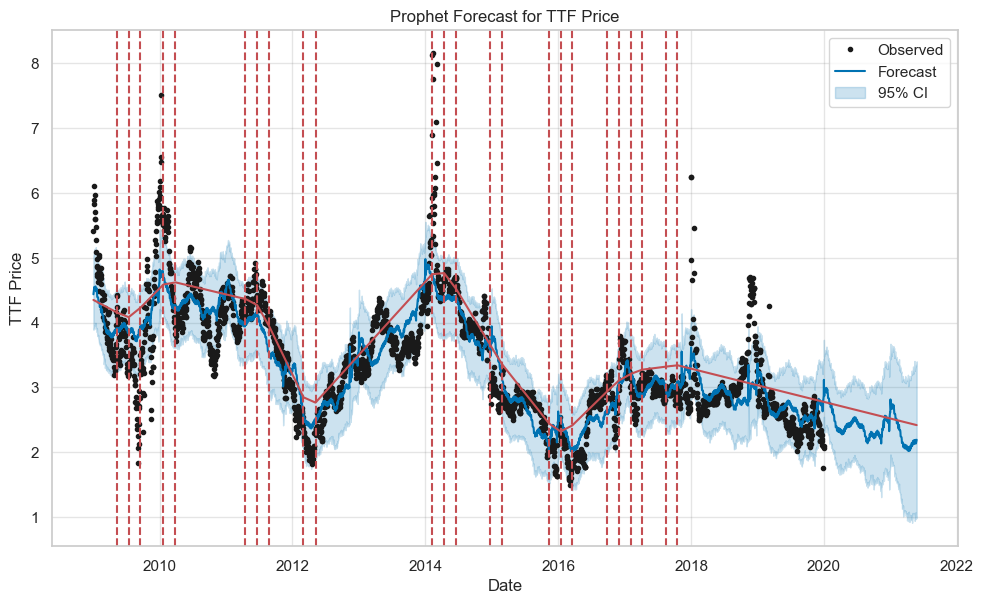

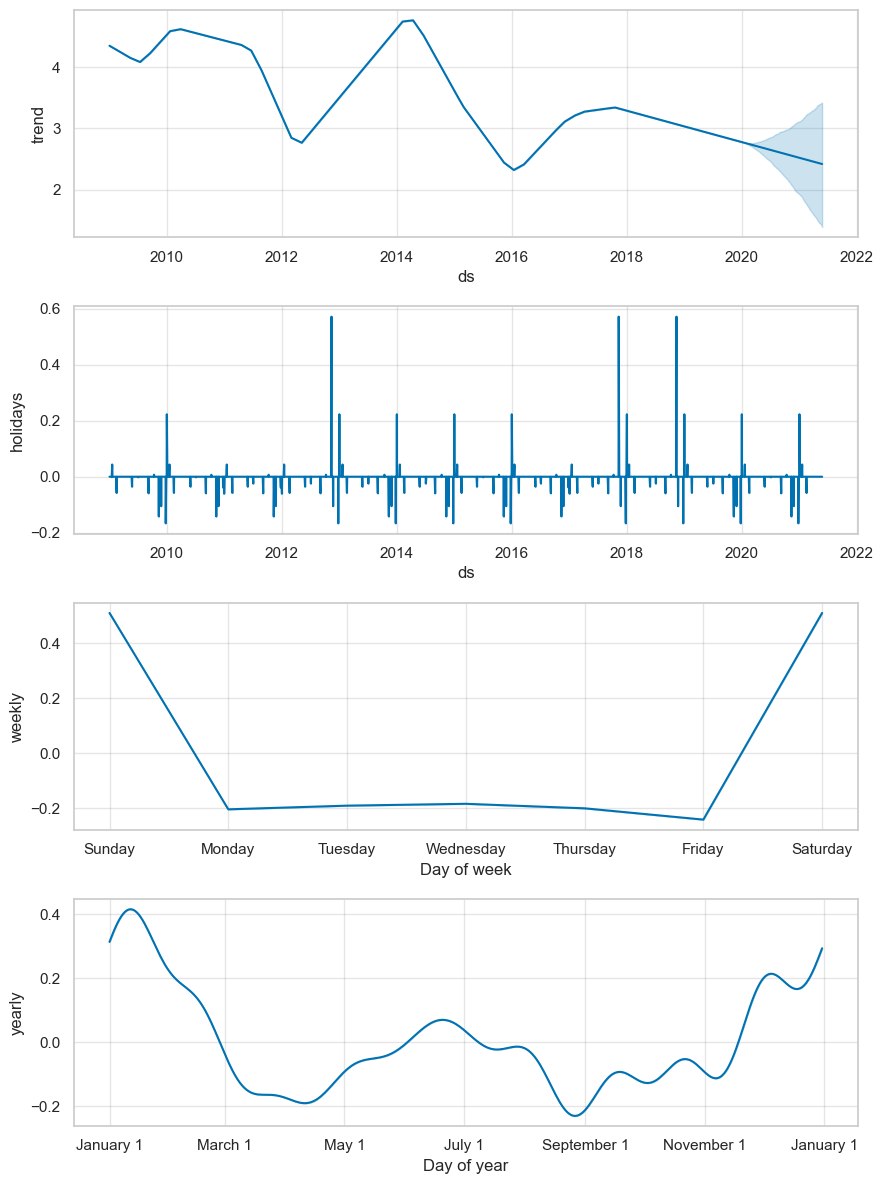

In [ ]:
# Fit Prophet model before 2019-1 (Covid-19 and Russia-Ukraine war)

whc = 'hh_price' # 'hh_price'

# Prepare the data for Prophet
start_date = '2000-01-01'
end_date = '2019-12-31'
series = data_prep(df, whc, date_range=(start_date, end_date))
df_prophet = series.reset_index().rename(columns={'date': 'ds', whc: 'y'})

# Fit the Prophet model
model = Prophet(n_changepoints=50)#, changepoints=changepoints)
model.add_country_holidays(country_name=price_column_country[whc])
model.fit(df_prophet)

future = model.make_future_dataframe(periods=365, freq='B')
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# plot the Prophet forecast
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
fig.set_size_inches(10, 6)
plt.title('Prophet Forecast for TTF Price')
plt.xlabel('Date')
plt.ylabel('TTF Price')
plt.legend(['Observed', 'Forecast', '95% CI'])

a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

model.plot_components(forecast)
plt.show()


# Conclusions & Practical Advice

- auto_arima is convenient for automated order selection but may pick models that do not account for structural breaks — always validate selected models on holdout periods.
- Prophet is a great drop-in option for changepoint and holiday-aware forecasting. Use domain-informed changepoints (major market events) and custom holidays when available.
- For production usage, combine Prophet's changepoint handling with exogenous regressors and cross-validate across event windows.